<a href="https://colab.research.google.com/github/NahinAlam001/CSE-465/blob/model/Latest_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Beyond the Cyst: A Holistic Approach to PCOS

##Libraries

In [1]:
import os
import gdown
import zipfile
import torch
import pandas as pd
import torchvision
from torch import nn
from pathlib import Path
from typing import Dict, List
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from PIL import Image
from google.colab import files
import torchvision.models as models

try:
  import torchinfo
  import torchmetrics
except:
  !pip install torchinfo
  !pip install torchmetrics
  import torchinfo
  import torchmetrics
from torchinfo import summary
from torchmetrics import Accuracy, Precision, Recall, F1Score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

##Data Collection

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Download and extract dataset
gdown.download('https://drive.google.com/uc?id=1DLWHOlGDNeQNRRuonzaSgwNiT_J1NDx1', 'pcos.zip', quiet=False)
with zipfile.ZipFile('pcos.zip', 'r' ) as zip_ref:
  zip_ref.extractall()

data_path = Path('data')
image_path = data_path/'images'
train_dir = image_path/'train'
test_dir = image_path/'test'

Downloading...
From (original): https://drive.google.com/uc?id=1DLWHOlGDNeQNRRuonzaSgwNiT_J1NDx1
From (redirected): https://drive.google.com/uc?id=1DLWHOlGDNeQNRRuonzaSgwNiT_J1NDx1&confirm=t&uuid=81734b79-912b-457a-aa45-870e9677d132
To: /content/pcos.zip
100%|██████████| 132M/132M [00:01<00:00, 92.5MB/s]


##Basic EDA

In [3]:
import os

def walk_through_dir(dir_path):
  '''Walks through directories and prints the number of pictures in them'''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} pictures in {dirpath}')

walk_through_dir(image_path)

There are 2 directories and 0 pictures in data/images
There are 2 directories and 0 pictures in data/images/train
There are 0 directories and 1143 pictures in data/images/train/notinfected
There are 0 directories and 781 pictures in data/images/train/infected
There are 2 directories and 0 pictures in data/images/test
There are 1 directories and 1141 pictures in data/images/test/notinfected
There are 0 directories and 0 pictures in data/images/test/notinfected/.ipynb_checkpoints
There are 1 directories and 781 pictures in data/images/test/infected
There are 0 directories and 0 pictures in data/images/test/infected/.ipynb_checkpoints


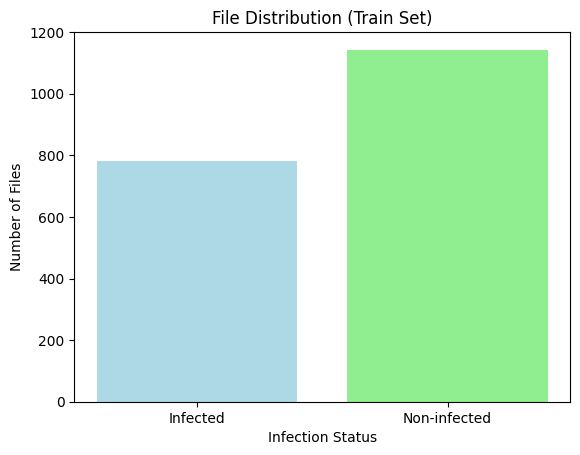

In [4]:
import matplotlib.pyplot as plt


def get_file_count(directory):
  """Counts the number of files in a directory."""
  return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])



infected_count = get_file_count(os.path.join(image_path, "train", "infected"))
non_infected_count = get_file_count(os.path.join(image_path, "train", "notinfected"))


labels = ['Infected', 'Non-infected']
file_counts = [infected_count, non_infected_count]


x_positions = range(len(labels))

colors = ['lightblue', 'lightgreen']

plt.bar(x_positions, file_counts, color=colors)
plt.xlabel('Infection Status')
plt.ylabel('Number of Files')
plt.title('File Distribution (Train Set)')


plt.xticks(x_positions, labels)


plt.show()

In [5]:
image_path_list = list(image_path.glob('*/*/*.jpg'))
len(image_path_list)

3842

Class: notinfected | Size: (850, 578)


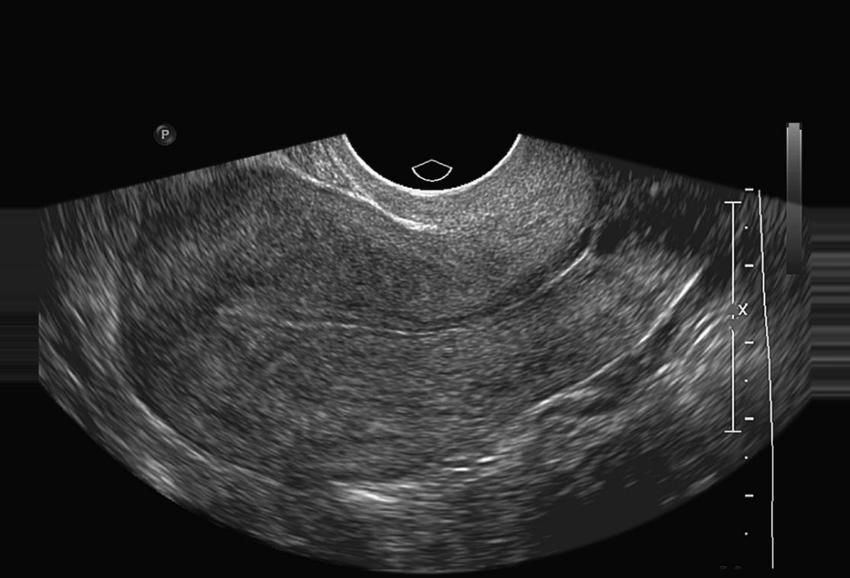

In [6]:
import random
from PIL import Image

random.seed(42)

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f'Class: {image_class} | Size: {img.size}')
img

(-0.5, 849.5, 577.5, -0.5)

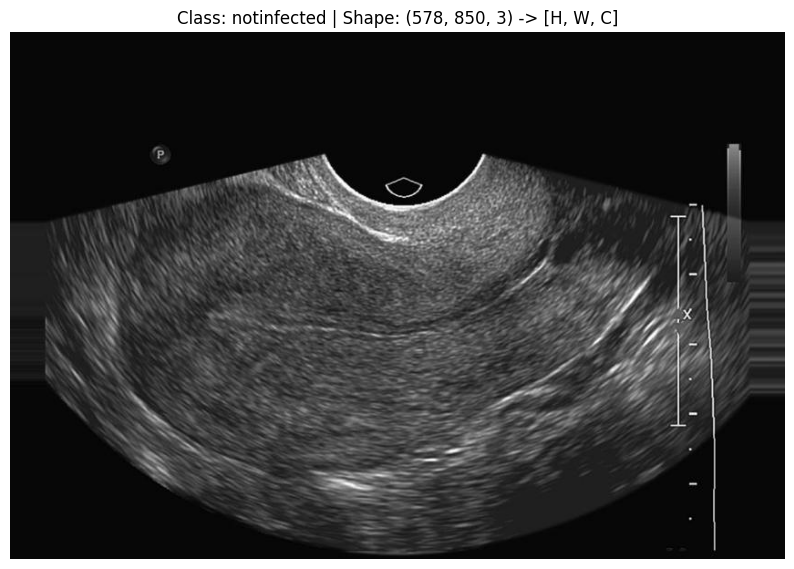

In [7]:
import numpy as np
import matplotlib.pyplot as plt

image_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(image_as_array)
plt.title(f'Class: {image_class} | Shape: {image_as_array.shape} -> [H, W, C]')
plt.axis(False)

In [8]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n = 3,
                            seed = None):
  '''
    Selects random images from a path of images and loads/transforms them. Plots the orginal vs the transformed version
  '''
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k= n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class:{image_path.parent.stem}', fontsize=16)

##Data Augmentation



In [15]:
transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    # TrivialAugmentWide(num_magnitude_bins=31),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

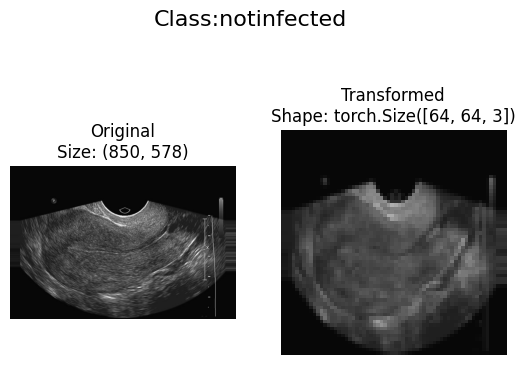

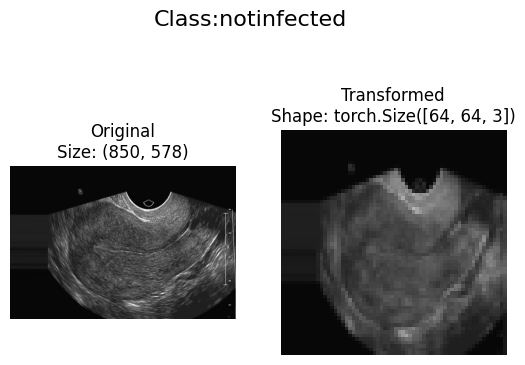

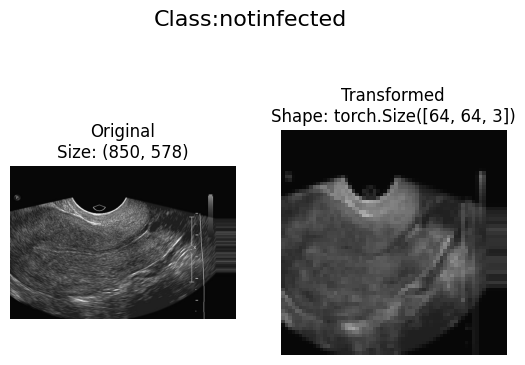

In [16]:
plot_transformed_images(image_paths = image_path_list,
                        transform = transform,
                        n = 3,
                        seed = 42)

##Creating Dataset

In [17]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                  transform = transform)

##DataLoader

In [18]:
class_names = train_data.classes
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_loader = DataLoader(dataset = train_data,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          num_workers = NUM_WORKERS)

test_loader = DataLoader(dataset = test_data,
                          batch_size = BATCH_SIZE,
                          shuffle = False,
                          num_workers = NUM_WORKERS)

In [19]:
batch_img, batch_label = next(iter(train_loader))
batch_img.shape, batch_label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

##CNN Model

In [20]:
class NahinGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_unit: int,
               output_shape: int)->None:

    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_unit,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_unit,
                  out_channels = hidden_unit,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2))

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_unit,
                  out_channels = hidden_unit,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_unit,
                  out_channels = hidden_unit,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2))

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 13*13*hidden_unit,
                  out_features = output_shape))

  def forward(self, x):
    return self.classifier(self.conv_block2(self.conv_block1(x)))

In [21]:
model_0 = NahinGG(input_shape = 3,
                  hidden_unit = 10,
                  output_shape = len(class_names)).to(device)

In [22]:
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
NahinGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

##Training

In [23]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    train_pred_logits = model(X)

    loss = loss_fn(train_pred_logits, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    train_pred_lables = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1)
    train_acc += (train_pred_lables == y).sum().item()/len(train_pred_lables)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [24]:
def test_step(model = torch.nn.Module,
              dataloader = torch.utils.data.DataLoader,
              loss_fn = torch.nn.Module,
              device = device):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_lables = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_lables == y).sum().item()/len(test_pred_lables)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

In [25]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device = device):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(f'Epoch {epoch} | Train Loss: {train_loss: .4f} | Train Accuracy: {train_acc: .4f} | Test Loss: {test_loss: .4f} | Test Accuracy: {test_acc: .4f}')

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

##Evaluation

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 1e-3)

start_time = timer()
model_0_results = train(model = model_0,
train_dataloader = train_loader,
test_dataloader = test_loader,
loss_fn = loss_fn,
optimizer = optimizer,
epochs = NUM_EPOCHS,
device = device)
end_time = timer()

print(f'Total Training Time: {end_time - start_time: .3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss:  0.6241 | Train Accuracy:  0.6634 | Test Loss:  0.3675 | Test Accuracy:  0.8197
Epoch 1 | Train Loss:  0.2872 | Train Accuracy:  0.8678 | Test Loss:  0.1956 | Test Accuracy:  0.9078
Epoch 2 | Train Loss:  0.1027 | Train Accuracy:  0.9636 | Test Loss:  0.0194 | Test Accuracy:  0.9985
Epoch 3 | Train Loss:  0.0049 | Train Accuracy:  1.0000 | Test Loss:  0.0021 | Test Accuracy:  1.0000
Epoch 4 | Train Loss:  0.0017 | Train Accuracy:  1.0000 | Test Loss:  0.0008 | Test Accuracy:  1.0000
Epoch 5 | Train Loss:  0.0007 | Train Accuracy:  1.0000 | Test Loss:  0.0005 | Test Accuracy:  1.0000
Epoch 6 | Train Loss:  0.0004 | Train Accuracy:  1.0000 | Test Loss:  0.0003 | Test Accuracy:  1.0000
Epoch 7 | Train Loss:  0.0003 | Train Accuracy:  1.0000 | Test Loss:  0.0002 | Test Accuracy:  1.0000
Epoch 8 | Train Loss:  0.0002 | Train Accuracy:  1.0000 | Test Loss:  0.0002 | Test Accuracy:  1.0000
Epoch 9 | Train Loss:  0.0002 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Tes

In [27]:
model_0_results

{'train_loss': [0.6240869872882718,
  0.28723061567202945,
  0.10268512618590574,
  0.004856793991419807,
  0.001675647379819506,
  0.0006854127512597784,
  0.00044904352347896107,
  0.00028215849870022913,
  0.0002015172443429574,
  0.000151029076517552],
 'train_acc': [0.663422131147541,
  0.867827868852459,
  0.9636270491803278,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'test_loss': [0.3675204657140325,
  0.19563936247475078,
  0.019356545860512702,
  0.002132592368980113,
  0.0008450654526999732,
  0.0004599311372402792,
  0.0003226198253389332,
  0.00021492316862654697,
  0.00016955106476693866,
  0.00013666953606435503],
 'test_acc': [0.819672131147541,
  0.9077868852459017,
  0.9984631147540983,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

##Results Plot

In [28]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train loss')
  plt.plot(epochs, test_loss, label='test loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train accuracy')
  plt.plot(epochs, test_accuracy, label='test accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  plt.show()

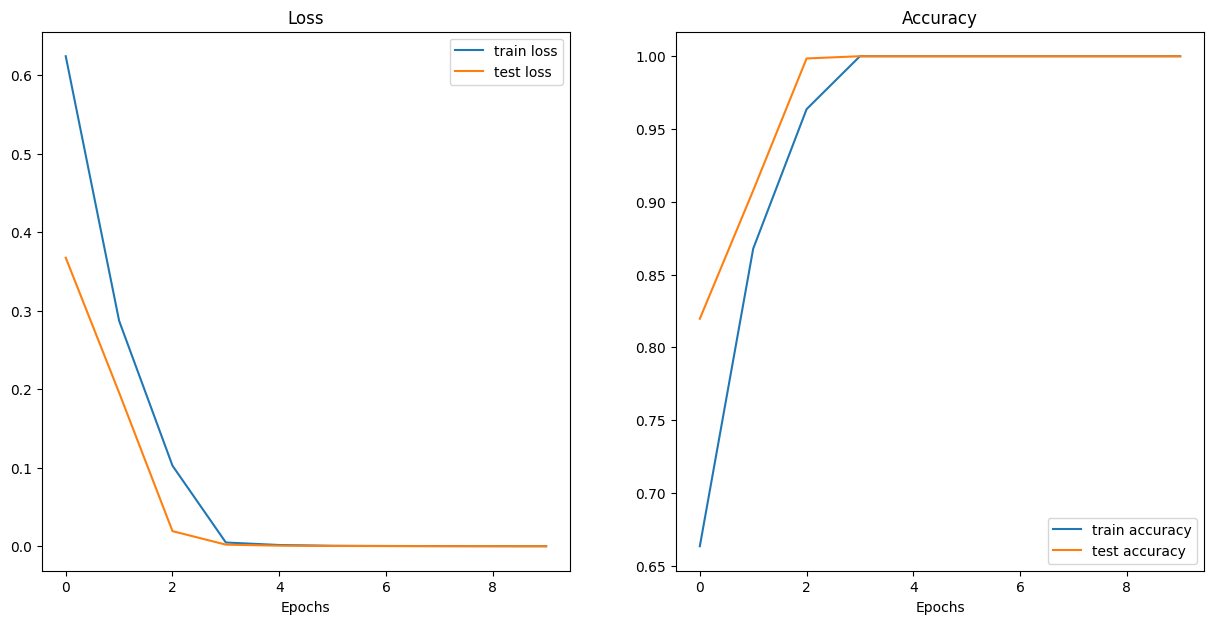

In [29]:
plot_loss_curves(model_0_results)

##Save the Model

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
model_save_path = '/content/drive/MyDrive/model_0.pth'
torch.save(model_0.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/drive/MyDrive/model_0.pth


##Load the Model

In [32]:
model_0_loaded = NahinGG(input_shape=3, hidden_unit=10, output_shape=len(class_names)).to(device)
model_0_loaded.load_state_dict(torch.load(model_save_path))
model_0_loaded.eval()

NahinGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)

##Load and process image

In [33]:
def load_and_preprocess_image(image_path):
  image = Image.open(image_path)
  image = transform(image).unsqueeze(0).to(device)
  return image

In [34]:
# def predict_image(image_path, model):
#   image = load_and_preprocess_image(image_path)
#   with torch.no_grad():
#     output = model(image)
#     _, predicted = torch.max(output, 1)
#     predicted_class = class_names[predicted.item()]
#   return predicted_class

In [61]:
def predict_image(image_path, model):
    image = load_and_preprocess_image(image_path)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]
        predicted_label = predicted.item()
    return predicted_class, predicted_label

In [46]:
uploaded = files.upload()

Saving normal.jpeg to normal.jpeg


##Predict Uploaded Image

In [47]:
for file_name in uploaded.keys():
  predicted_class = predict_image(file_name, model_0_loaded)
  print(f'The model predicts that the image {file_name} is: {predicted_class}')

The model predicts that the image normal.jpeg is: notinfected


##More Evaluation Scores

In [37]:
model_0_df = pd.DataFrame(model_0_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,0.624087,0.663422,0.367520,0.819672
1,0.287231,0.867828,0.195639,0.907787
2,0.102685,0.963627,0.019357,0.998463
3,0.004857,1.000000,0.002133,1.000000
4,0.001676,1.000000,0.000845,1.000000
5,0.000685,1.000000,0.000460,1.000000
6,0.000449,1.000000,0.000323,1.000000
7,0.000282,1.000000,0.000215,1.000000
8,0.000202,1.000000,0.000170,1.000000
9,0.000151,1.000000,0.000137,1.000000


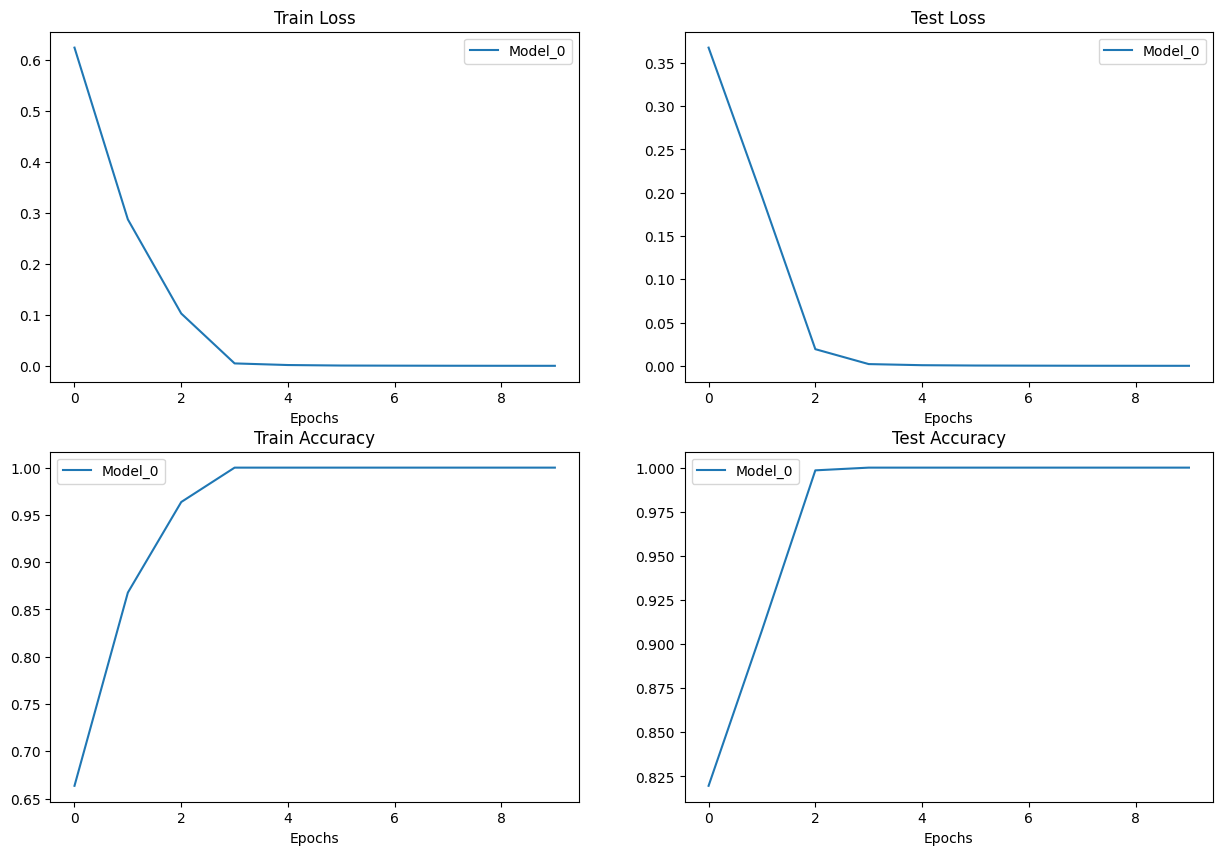

In [38]:
plt.figure(figsize=(15, 10))
epochs = range(len(model_0_df))

plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label = 'Model_0')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label = 'Model_0')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label = 'Model_0')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label = 'Model_0')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [63]:
class_dict = train_data.class_to_idx
class_dict

{'infected': 0, 'notinfected': 1}

In [64]:
# Initialize metrics
accuracy_metric = Accuracy(task='binary').to(device)
precision_metric = Precision(task='binary', average='weighted').to(device)
recall_metric = Recall(task='binary', average='weighted').to(device)
f1_metric = F1Score(task='binary', average='weighted').to(device)

# Initialize lists to hold true labels and predictions
true_labels = []
predictions = []

# Predict the uploaded image
for file_name in uploaded.keys():
    predicted_class, predicted_label = predict_image(file_name, model_0_loaded)
    print(f'The model predicts that the image {file_name} is: {predicted_class}')
    true_label = int(input(f'Enter the true class index for {file_name} (0 for class_0, 1 for class_1, etc.): '))
    true_labels.append(true_label)
    predictions.append(predicted_label)

# Convert lists to tensors
true_labels_tensor = torch.tensor(true_labels).to(device)
predictions_tensor = torch.tensor(predictions).to(device)

# Calculate evaluation metrics
accuracy = accuracy_metric(predictions_tensor, true_labels_tensor)
precision = precision_metric(predictions_tensor, true_labels_tensor)
recall = recall_metric(predictions_tensor, true_labels_tensor)
f1 = f1_metric(predictions_tensor, true_labels_tensor)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

The model predicts that the image normal.jpeg is: notinfected
Enter the true class index for normal.jpeg (0 for class_0, 1 for class_1, etc.): 1
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


##Transfer Learning

Training model: resnet18


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss:  0.0659 | Train Accuracy:  0.9775 | Test Loss:  0.0003 | Test Accuracy:  1.0000
Epoch 1 | Train Loss:  0.1039 | Train Accuracy:  0.9918 | Test Loss:  0.0013 | Test Accuracy:  1.0000
Epoch 2 | Train Loss:  0.0174 | Train Accuracy:  0.9959 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 3 | Train Loss:  0.0098 | Train Accuracy:  0.9959 | Test Loss:  0.0007 | Test Accuracy:  1.0000
Epoch 4 | Train Loss:  0.0002 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 5 | Train Loss:  0.0001 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 6 | Train Loss:  0.0001 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 7 | Train Loss:  0.0001 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 8 | Train Loss:  0.0000 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 9 | Train Loss:  0.0001 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Tes

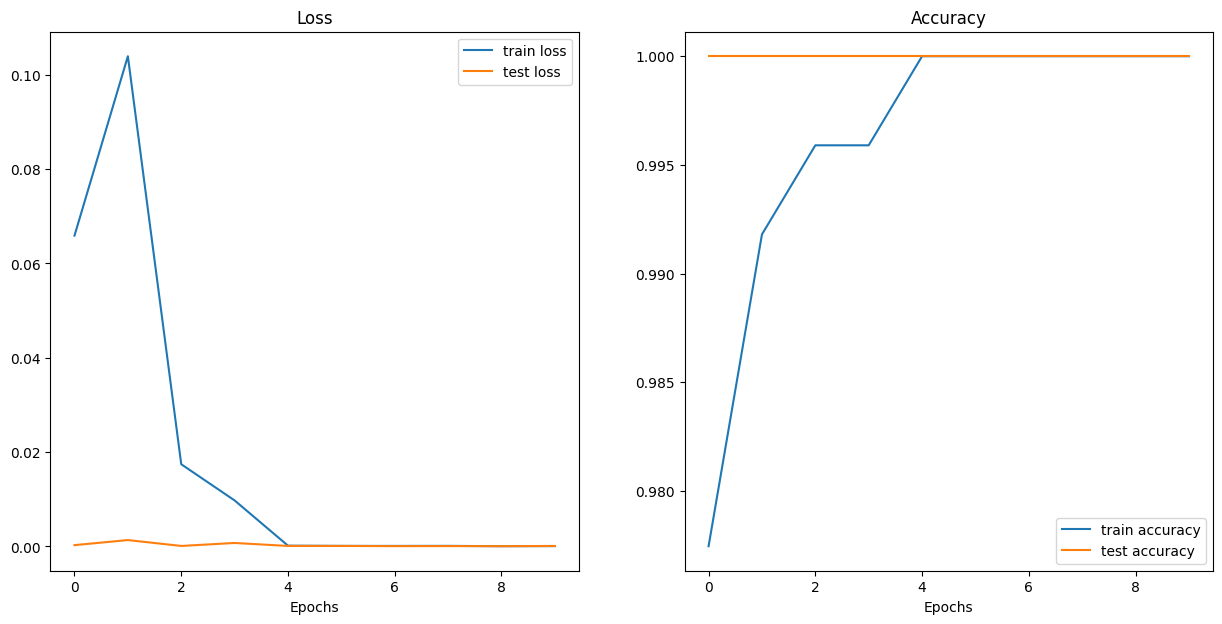

Training model: resnet34


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 160MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss:  0.0540 | Train Accuracy:  0.9749 | Test Loss:  0.0607 | Test Accuracy:  0.9723
Epoch 1 | Train Loss:  0.0999 | Train Accuracy:  0.9887 | Test Loss:  0.0070 | Test Accuracy:  0.9969
Epoch 2 | Train Loss:  0.1389 | Train Accuracy:  0.9913 | Test Loss:  0.0010 | Test Accuracy:  1.0000
Epoch 3 | Train Loss:  0.0120 | Train Accuracy:  0.9974 | Test Loss:  0.0038 | Test Accuracy:  0.9995
Epoch 4 | Train Loss:  0.0047 | Train Accuracy:  0.9995 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 5 | Train Loss:  0.0005 | Train Accuracy:  1.0000 | Test Loss:  0.0002 | Test Accuracy:  1.0000
Epoch 6 | Train Loss:  0.0002 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 7 | Train Loss:  0.0737 | Train Accuracy:  0.9918 | Test Loss:  0.0003 | Test Accuracy:  1.0000
Epoch 8 | Train Loss:  0.0896 | Train Accuracy:  0.9882 | Test Loss:  0.1078 | Test Accuracy:  0.9513
Epoch 9 | Train Loss:  0.0305 | Train Accuracy:  0.9923 | Test Loss:  0.0003 | Tes

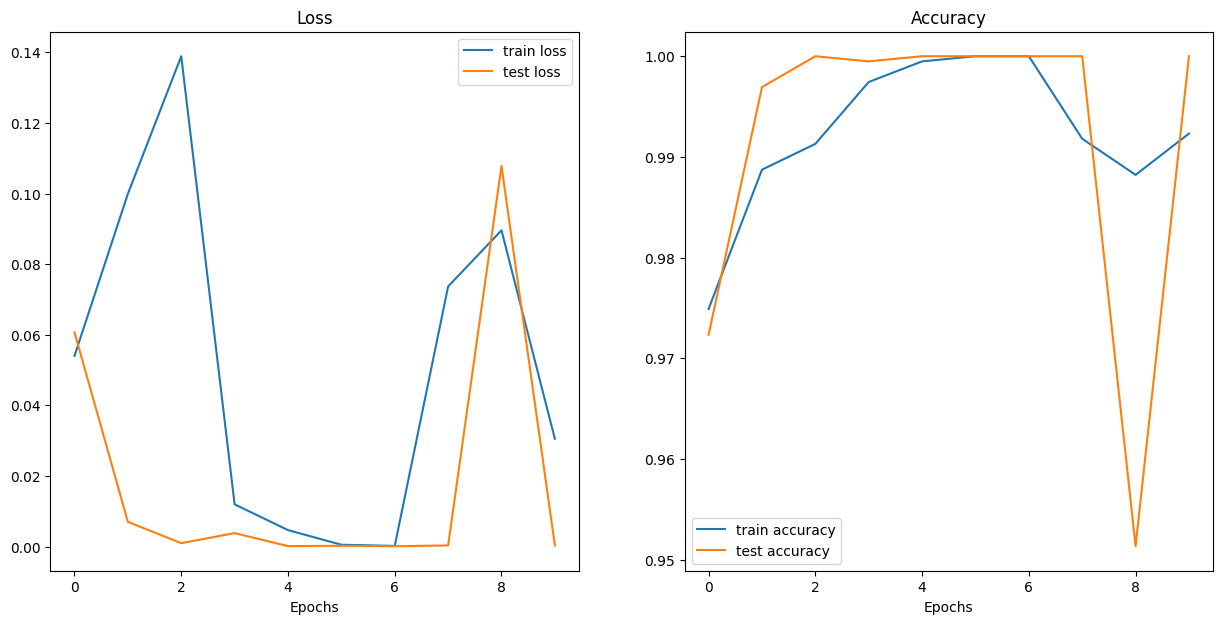

Training model: resnet50


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss:  0.1499 | Train Accuracy:  0.9723 | Test Loss:  0.0004 | Test Accuracy:  1.0000
Epoch 1 | Train Loss:  0.0284 | Train Accuracy:  0.9949 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 2 | Train Loss:  0.0008 | Train Accuracy:  1.0000 | Test Loss:  0.0000 | Test Accuracy:  1.0000
Epoch 3 | Train Loss:  0.1382 | Train Accuracy:  0.9877 | Test Loss:  0.0005 | Test Accuracy:  1.0000
Epoch 4 | Train Loss:  0.0375 | Train Accuracy:  0.9923 | Test Loss:  0.0009 | Test Accuracy:  0.9995
Epoch 5 | Train Loss:  0.0298 | Train Accuracy:  0.9944 | Test Loss:  0.6034 | Test Accuracy:  0.9467
Epoch 6 | Train Loss:  0.0142 | Train Accuracy:  0.9959 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 7 | Train Loss:  0.0002 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 8 | Train Loss:  0.0001 | Train Accuracy:  1.0000 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 9 | Train Loss:  0.0754 | Train Accuracy:  0.9959 | Test Loss:  0.0000 | Tes

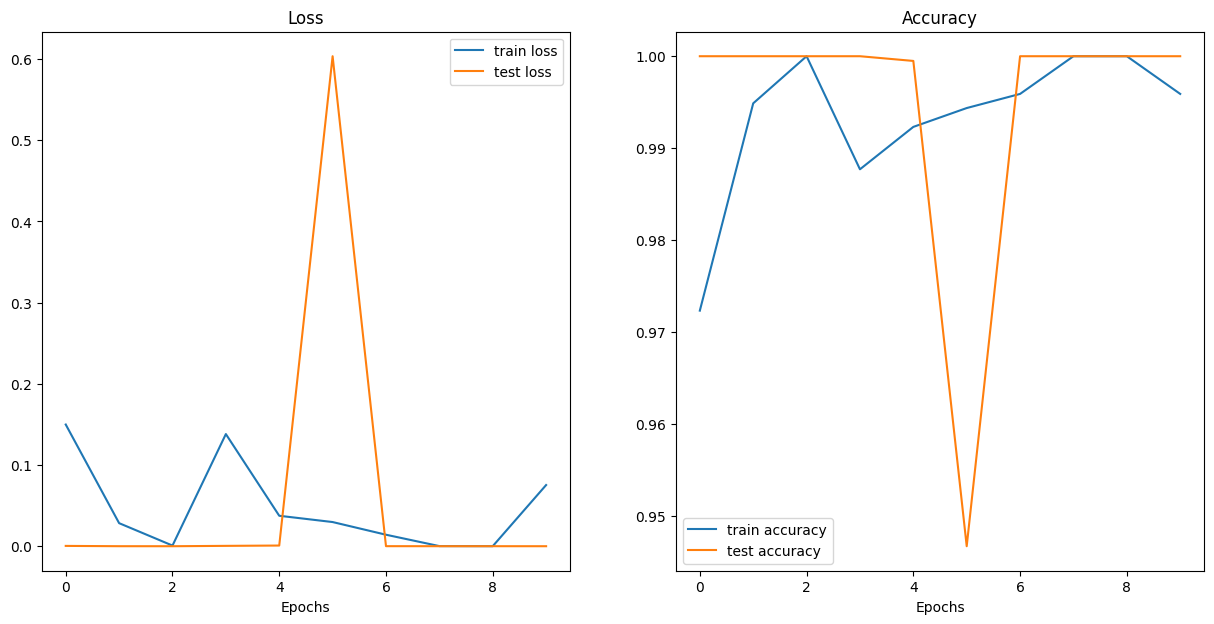

Training model: densenet121


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 112MB/s] 


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss:  0.0349 | Train Accuracy:  0.9831 | Test Loss:  0.0018 | Test Accuracy:  1.0000
Epoch 1 | Train Loss:  0.0019 | Train Accuracy:  0.9995 | Test Loss:  0.0004 | Test Accuracy:  1.0000
Epoch 2 | Train Loss:  0.0004 | Train Accuracy:  1.0000 | Test Loss:  0.0000 | Test Accuracy:  1.0000
Epoch 3 | Train Loss:  0.0000 | Train Accuracy:  1.0000 | Test Loss:  0.0000 | Test Accuracy:  1.0000
Epoch 4 | Train Loss:  0.0000 | Train Accuracy:  1.0000 | Test Loss:  0.0000 | Test Accuracy:  1.0000
Epoch 5 | Train Loss:  0.0712 | Train Accuracy:  0.9959 | Test Loss:  0.0403 | Test Accuracy:  0.9810
Epoch 6 | Train Loss:  0.0384 | Train Accuracy:  0.9923 | Test Loss:  0.1463 | Test Accuracy:  0.9360
Epoch 7 | Train Loss:  0.0080 | Train Accuracy:  0.9964 | Test Loss:  0.0001 | Test Accuracy:  1.0000
Epoch 8 | Train Loss:  0.0415 | Train Accuracy:  0.9959 | Test Loss:  0.0235 | Test Accuracy:  0.9949
Epoch 9 | Train Loss:  0.0229 | Train Accuracy:  0.9969 | Test Loss:  0.0085 | Tes

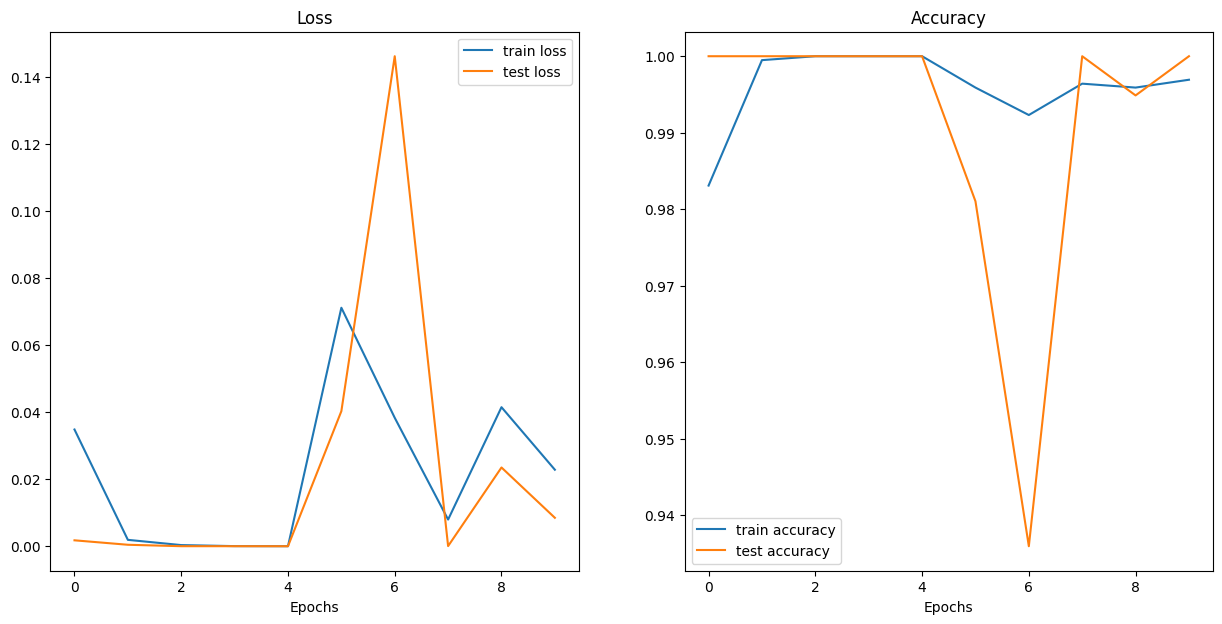

In [59]:
# Define a dictionary of pre-trained models to loop through
pretrained_models = {
    "resnet18": models.resnet18,
    "resnet34": models.resnet34,
    "resnet50": models.resnet50,
    "densenet121": models.densenet121
}

# Loop through each pre-trained model and train it
for model_name, model_fn in pretrained_models.items():
    print(f"Training model: {model_name}")
    # Initialize the model
    num_classes = len(train_data.classes)
    model = model_fn(pretrained=True)
    if 'fc' in model.__dict__['_modules']:  # For ResNet models
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'classifier' in model.__dict__['_modules']:  # For DenseNet models
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model_results = train(model=model,
                          train_dataloader=train_loader,
                          test_dataloader=test_loader,
                          loss_fn=criterion,
                          optimizer=optimizer,
                          epochs=NUM_EPOCHS)

    # Plot loss curves
    plot_loss_curves(model_results)